# Bibliotecas

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.neural_network import MLPRegressor as rede_neural
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from scipy.stats import f_oneway
from sklearn.model_selection import GridSearchCV
import Classes as Cls
import pickle
import math

# Funções

In [83]:
def describe_dist_var(dataframe_1,dataframe_2,var):
    distancias_var = {}
        
    for periodo in range(52):
        aux = []
        for list_1 in dataframe_1[var]:
            for list_2 in dataframe_2[var]:
                aux.append(math.fabs(list_1[periodo]-list_2[periodo]))
        distancias_var[f'x{periodo+1}'] = aux

    return pd.DataFrame(distancias_var)

In [84]:
def describe_var(dataframe,var):
    resultado_var = {}
    
    for periodo in range(52):
        aux = []
        for list in dataframe[var]:
            aux.append(list[periodo])
        resultado_var[f'{var}{periodo+1}'] = aux

    return pd.DataFrame(resultado_var)

In [85]:
def describe_var_grafico(describe1_var,describe2_var,var):
    fig=plt.figure(figsize=(4,4))

    plt.plot(range(52),describe1_var.iloc[1,:],color='blue',label='Floresta Aleatória')
    plt.plot(range(52),describe2_var.iloc[1,:],color='red',label='Rede Neural')

    plt.xlabel('Componente de '+var)
    plt.ylabel('Valor Médio')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Imgs\{var}Medio.png', format='png')
    plt.show()


In [86]:
def describe_var_desv_grafico(describe1_var,describe2_var,var):
    fig=plt.figure(figsize=(4,4))

    plt.plot(range(52),describe1_var.iloc[2,:],color='blue',label='Floresta Aleatória')
    plt.plot(range(52),describe2_var.iloc[2,:],color='red',label='Rede Neural')

    plt.xlabel('Componente de '+var)
    plt.ylabel('Desvio Padrão')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Imgs\{var}FrdvioPadrao.png', format='png')
    plt.show()

In [87]:
def plot_dist(describe_dist_var,var):
    fig=plt.figure(figsize=(4,4))

    plt.plot(range(52),describe_dist_var.iloc[1,:])
    plt.xlabel('Componente de '+var)
    plt.ylabel('Distância Média')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'Imgs\{var}DistMedia.png', format='png')
    plt.show()

# Importação dos modelos de aprendizado

In [88]:
n=10

funcao_demanda = lambda i,j: [(i*6-j*2)**2+10000]

x = [[j] for j in range(52) for i in range(n)]

y = pd.read_csv('Resultados/demandas')['y'].values

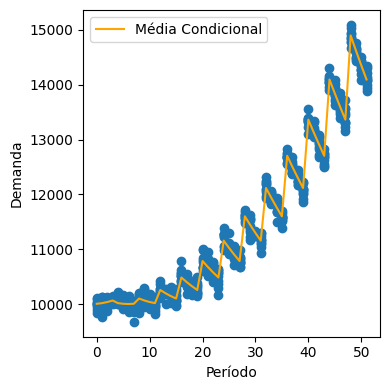

In [89]:
fig=plt.figure(figsize=(4,4))

plt.scatter(x,y)


x_unique = [[i] for i in range(52)]

medias_reais = [funcao_demanda(i,j) for i in range(13) for j in range(1,5)]

plt.plot(x_unique,medias_reais,color='orange',label='Média Condicional')

plt.ylabel('Demanda')
plt.xlabel('Período')
plt.legend()
plt.tight_layout()
plt.savefig('Imgs\demandas.png', format='png')

plt.show()

In [90]:
with open("Resultados/modelos_binarios", "rb") as arquivo_binario:
  while True:
    try:
        modelos = pickle.load(arquivo_binario)
    except EOFError:
        break

In [91]:
resultados = pd.DataFrame({'Random forest': modelos.medias_desempenho[0],
                           'Rede Neural': modelos.medias_desempenho[1],})

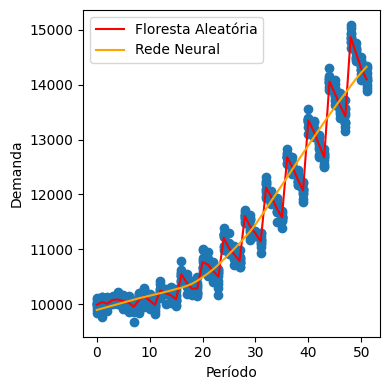

In [92]:
fig=plt.figure(figsize=(4,4))

plt.scatter(x,y)
plt.plot(x_unique,modelos.y_scale.inverse_transform(modelos.Predizer(0,x_unique).reshape(-1,1)),color='red',label='Floresta Aleatória')

plt.plot(x_unique,modelos.y_scale.inverse_transform(modelos.Predizer(1,x_unique).reshape(-1,1)),color='orange',label='Rede Neural')


plt.ylabel('Demanda')
plt.xlabel('Período')

plt.legend()
plt.tight_layout()
plt.savefig('Imgs\demandas_reg.png', format='png')
plt.show()

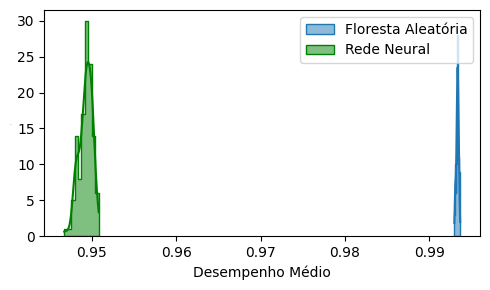

In [93]:
fig=plt.figure(figsize=(5,3))
sns.histplot(modelos.medias_desempenho[0], kde=True, element='step',label='Floresta Aleatória')
sns.histplot(modelos.medias_desempenho[1], kde=True, element='step',color='green',label='Rede Neural')
plt.xlabel('Desempenho Médio')
plt.ylabel([], fontsize=0)
plt.legend()
plt.tight_layout()
plt.savefig('Imgs\distribuiçao_desempenhos.png', format='png')
plt.show()

In [94]:
resultados.describe()

,Random forest,Rede Neural
count,120.000000,120.000000
mean,0.993315,0.949295
std,0.000145,0.000788
min,0.992950,0.946759
25%,0.993234,0.948827
50%,0.993329,0.949407
75%,0.993409,0.949907
max,0.993645,0.950840


## Analise de Normalidade dos dados de desempenho médio

In [95]:
alpha = 0.05
p={}
_,p['Random Forest'] = shapiro(modelos.medias_desempenho[0])
_,p['Rede Neural'] = shapiro(modelos.medias_desempenho[1])
#H0=seguem distribuição normal
for i in p:
    if p[i] <= alpha:
        print(f'Média amostral de desempenho da {i} não segue uma normal')
    else:
        print(f'Não pode rejeitar a hipotese de normalidade para os desempenhos médio da {i}')

Não pode rejeitar a hipotese de normalidade para os desempenhos médio da Random Forest
Média amostral de desempenho da Rede Neural não segue uma normal


## Analise de comparação dos dados de desempenho médio

In [96]:
_,aux = f_oneway(modelos.medias_desempenho[0],modelos.medias_desempenho[1])

In [97]:
if aux < alpha:  
    print("A hipotese nula pode ser rejeitada. Dados provem de distribuição diferentes")
else:
    print("A hipotese nula não pode ser rejeitada. Dados provem da mesma distribuição")

A hipotese nula pode ser rejeitada. Dados provem de distribuição diferentes


# Resultados Modelo PI

## Importação dos Dados

In [98]:
resultados_1 = pd.read_csv('Resultados/Resultados_PI_RF').iloc[:,1:]
resultados_2 = pd.read_csv('Resultados/Resultados_PI_RN').iloc[:,1:]

In [99]:
resultados_dataframe_1 = {}
for column in range(len(resultados_1.columns[:-1])):
    coluna_aux = []
    for element in range(len((resultados_1.iloc[:,column]))):
        coluna_aux.append(np.array([float(elemento) for elemento in resultados_1.iloc[element,column][1:-1].split(',')]))
    
    resultados_dataframe_1[resultados_1.columns[column]] = coluna_aux

resultados_dataframe_1['ObjVal'] = resultados_1['ObjVal']

resultados_dataframe_1 = pd.DataFrame(resultados_dataframe_1)

In [100]:
resultados_dataframe_2 = {}
for column in range(len(resultados_2.columns[:-1])):
    coluna_aux = []
    for element in range(len((resultados_2.iloc[:,column]))):
        coluna_aux.append(np.array([float(elemento) for elemento in resultados_2.iloc[element,column][1:-1].split(',')]))
    
    resultados_dataframe_2[resultados_2.columns[column]] = coluna_aux

resultados_dataframe_2['ObjVal'] = resultados_2['ObjVal']

resultados_dataframe_2 = pd.DataFrame(resultados_dataframe_2)
        

## Comparação dos valores que cada componente de cada variavel toma

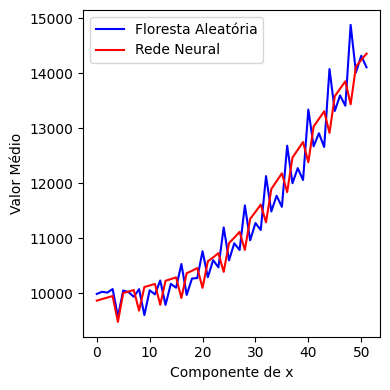

In [101]:
describe1_x = describe_var(resultados_dataframe_1,'x').describe()
describe2_x = describe_var(resultados_dataframe_2,'x').describe()

describe_var_grafico(describe1_x,describe2_x,'x')

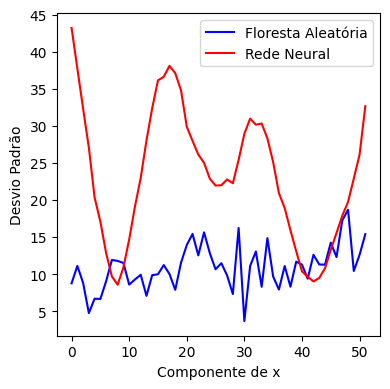

In [102]:
describe_var_desv_grafico(describe1_x,describe2_x,'x')

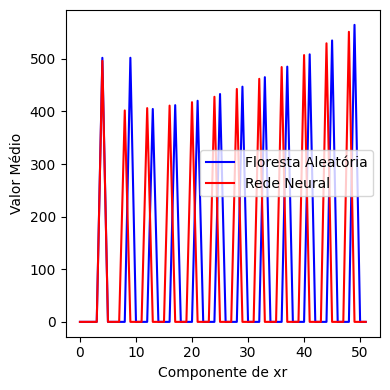

In [103]:
describe1_xr = describe_var(resultados_dataframe_1,'xr').describe()
describe2_xr = describe_var(resultados_dataframe_2,'xr').describe()
describe_var_grafico(describe1_xr,describe2_xr,'xr')

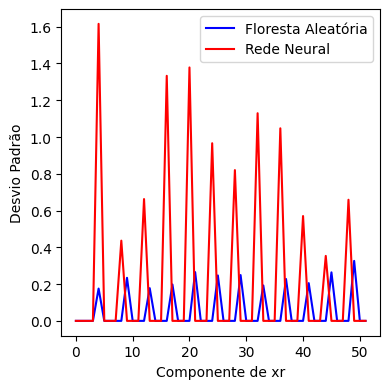

In [104]:
describe_var_desv_grafico(describe1_xr,describe2_xr,'xr')

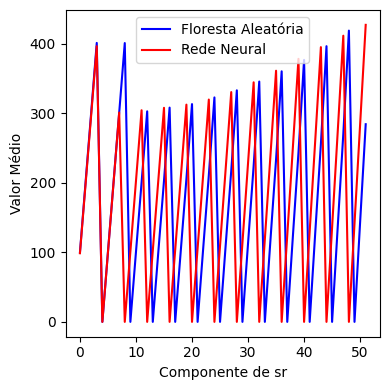

In [105]:
describe1_sr = describe_var(resultados_dataframe_1,'sr').describe()
describe2_sr = describe_var(resultados_dataframe_2,'sr').describe()
describe_var_grafico(describe1_sr,describe2_sr,'sr')

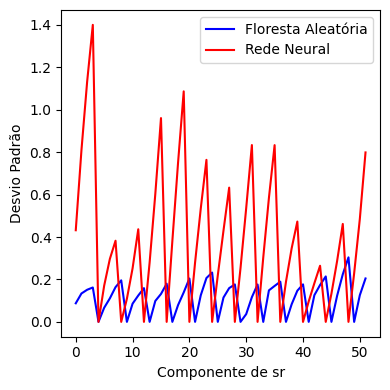

In [106]:
describe_var_desv_grafico(describe1_sr,describe2_sr,'sr')

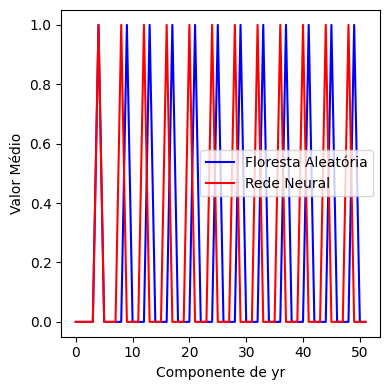

In [107]:
describe1_yr = describe_var(resultados_dataframe_1,'yr').describe()
describe2_yr = describe_var(resultados_dataframe_2,'yr').describe()
describe_var_grafico(describe1_yr,describe2_yr,'yr')

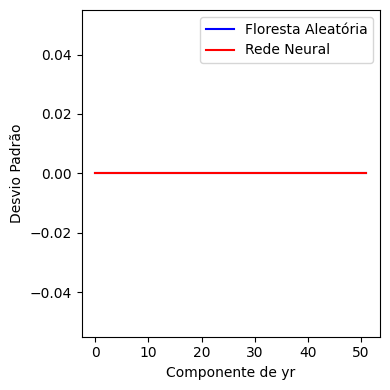

In [108]:
describe_var_desv_grafico(describe1_yr,describe2_yr,'yr')

### distancia entre os pontos provindos dos resultados do Random Forest e entre da Rede Neural

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


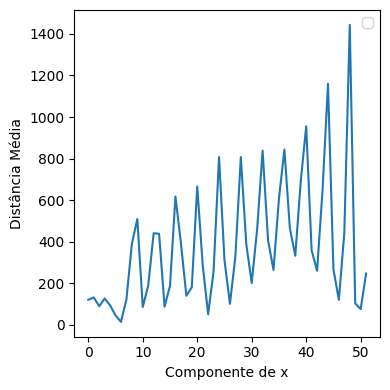

In [109]:
describe_x_3 = describe_dist_var(resultados_dataframe_1,resultados_dataframe_2,'x').describe()
plot_dist(describe_x_3,'x') 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


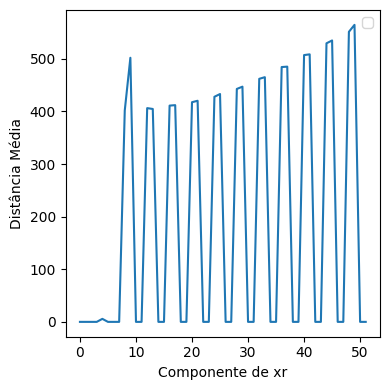

In [110]:
describe_xr_3 = describe_dist_var(resultados_dataframe_1,resultados_dataframe_2,'xr').describe()
plot_dist(describe_xr_3,'xr')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


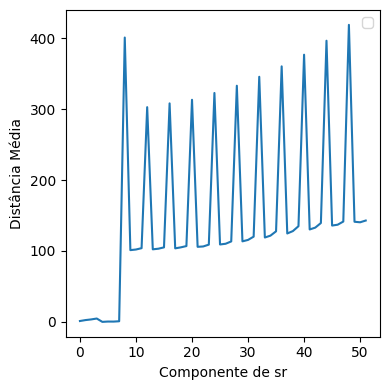

In [111]:
describe_sr_3 = describe_dist_var(resultados_dataframe_1,resultados_dataframe_2,'sr').describe()
plot_dist(describe_sr_3,'sr')

## Analise dos valores objetivos obtidos


[]

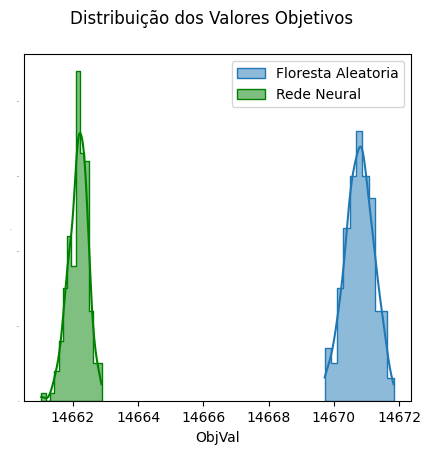

In [112]:
fig=plt.figure(figsize=(5,4.5))
fig.suptitle('Distribuição dos Valores Objetivos')

sns.histplot(resultados_dataframe_2['ObjVal'], kde=True, element='step',label='Floresta Aleatoria')
sns.histplot(resultados_dataframe_1['ObjVal'], kde=True, element='step',color='green',label='Rede Neural')
plt.legend()
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)
plt.plot()

Random Forest

In [113]:
resultados_dataframe_1['ObjVal'].describe()

count      200.000000
mean     14662.156221
std          0.300320
min      14661.031965
25%      14661.948779
50%      14662.173511
75%      14662.358905
max      14662.876202
Name: ObjVal, dtype: float64

Rede Neural

In [114]:
resultados_dataframe_2['ObjVal'].describe()

count      200.000000
mean     14670.781649
std          0.431803
min      14669.717974
25%      14670.485688
50%      14670.796482
75%      14671.097517
max      14671.830912
Name: ObjVal, dtype: float64

In [115]:
alpha = 0.05
p={}
_,p['Random Forest'] = shapiro(resultados_dataframe_1['ObjVal'])
_,p['Rede Neural'] = shapiro(resultados_dataframe_2['ObjVal'])
for i in p:
    if p[i] <= alpha:
        print(f'Média amostral de desempenho da {i} não segue uma normal')
    else:
        print(f'Não pode rejeitar a hipotese de normalidade para os desempenhos médio da {i}')

Não pode rejeitar a hipotese de normalidade para os desempenhos médio da Random Forest
Não pode rejeitar a hipotese de normalidade para os desempenhos médio da Rede Neural


In [116]:
_,aux = f_oneway(resultados_dataframe_1['ObjVal'].values,resultados_dataframe_2['ObjVal'].values)

In [117]:
if aux < alpha:  
    print("A hipotese nula pode ser rejeitada. Dados provem de distribuições diferentes")
else:
    print("A hipotese nula não pode ser rejeitada. Dados provem da mesma distribuição")

A hipotese nula pode ser rejeitada. Dados provem de distribuições diferentes
